Análisis de datos usando SparkR
===

* *30 min* | Última modificación: Junio 22, 2019

En este tutorial se presenta el análisis de una base de datos sobre vuelos usando SQL en Spark desde la interfaz de R. En este documento se ejemplifica el uso de DataFrames para la realización de consultas usando sus funciones nativas, como también el envio de comandos SQL. Adicionalmente, se demuestra como salvar los resultados al HDFS en distintos formatos. 

Al finalizar este documento, el lector estará en capacidad de:

* Mover archivos entre el HDFS y el sistema local.

* Importar tablas en formato CSV a SparkR.

* Aplicar operadores de selección, filtrado y agregación desde R.

* Usar los resultados obtenidos para construir gráficos.

* Exportar los resultados a archivos en el sistema HDFS.

Este ejemplo está basado en el tutorial de Spark de HortoWorks, disponible en https://es.hortonworks.com/tutorial/learning-spark-sql-with-zeppelin/

En este tutorial se ejemplican los mismos comandos usados en el tutorial 'Análisis de datos usando PySpark', por lo que aquí solo se ilustra la sintaxis usada; para obtener información detallada, debe verse el tutorial citado.

## Preparación

In [1]:
##
## Esta función se usará para ejecutar comandos en el 
## sistema operativo y capturar la salida.
##
systemp <- function(command) cat(system(command, intern = TRUE), sep = '\n')

In [2]:
library(SparkR)
sparkR.session(enableHiveSupport = TRUE)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Spark package found in SPARK_HOME: /usr/local/spark-2.4.0


Launching java with spark-submit command /usr/local/spark-2.4.0/bin/spark-submit   sparkr-shell /tmp/RtmpshPvjt/backend_portb80694bda87 


Warning message in sparkR.session(enableHiveSupport = TRUE):
“Version mismatch between Spark JVM and SparkR package. JVM version was 2.4.0 , while R package version was 2.4.3”

Java ref type org.apache.spark.sql.SparkSession id 1 

## Copia de archivos al HDFS

In [3]:
##
## El archivo flights.csv se encuentra en la capeta de
## trabajo de la máquina local. Se copia el archivo 
## a la carpeta /tmp del sistema HDFS.
##
systemp('hdfs dfs -copyFromLocal flights.csv /tmp/')

##
## Se listan los archivos en la carpeta /tmp del HDFS
## para verificar que el archivo haya sido copiado
##
systemp('hdfs dfs -ls /tmp/*csv')


-rw-r--r--   1 vagrant supergroup    9719582 2019-05-20 23:36 /tmp/flights.csv


## Carga de datos en Spark

In [4]:
##
## Crea un DataFrame a partir del archivo fligths.csv
##
flights <- read.df("/tmp/flights.csv",
                   "csv", 
                   header="true")

In [5]:
##
## Se imprime el esquema para verificar la lectura
## del archivo.
##
printSchema(flights)

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [6]:
## 
## Se imprime un subconjunto de las columnas para verificar
## la lectura
##
head(select(flights, 'UniqueCarrier', 'FlightNum', 'DepDelay', 'ArrDelay', 'Distance'))

UniqueCarrier FlightNum DepDelay ArrDelay Distance
1 WN            335       8        -14      810     
2 WN            3231      19       2        810     
3 WN            448       8        14       515     
4 WN            1746      -4       -6       515     
5 WN            3920      34       34       515     
6 WN            378       25       11       688

In [7]:
##
## Número total de registros leidos
##
numTotalFlights <- count(flights)
numTotalFlights

[1] 1e+05

## Cálculos usando funciones de los DataFrames

### Cómputo del porcentaje de vuelos retrasados

In [8]:
##
## La variable delayedFlights contiene las columnas 
## UniqueCarrier y DepDelay para los vuelos con 
## DepDelay > 15 minutos.
##
delayedFlights <- select(filter(flights, flights$DepDelay > 15), c('UniqueCarrier', 'DepDelay'))
head(delayedFlights)

UniqueCarrier DepDelay
1 WN            19      
2 WN            34      
3 WN            25      
4 WN            67      
5 WN            94      
6 WN            27

In [9]:
##
## Porcentaje de vuelos retrasados.
##
numDelayedFlights <- count(delayedFlights)
cat("Porcentaje de vuelos retrasados: ", numDelayedFlights / numTotalFlights * 100, "%")

Porcentaje de vuelos retrasados:  19.587 %

### Creación de campos

A continuación se desea crear una nueva columna llamada `IsDelayed` que vale 0 si el vuelo se realizó a tiempo y 1 si se retraso.

In [10]:
##
## Selecciona algunos campos del DataFrame original
##
flightsWithDelays <- select(flights, c('Year', 
                                       'Month',
                                       'DayofMonth', 
                                       'UniqueCarrier', 
                                       'FlightNum', 
                                       'DepDelay'))
                                   
##
## Crea un nuevo campo, como computo de otro existente
##
flightsWithDelays$IsDelayed <- ifelse(flightsWithDelays$DepDelay > 15, 1, 0)


##
## Se imprimen algunos registros para verificar el resultado.
##
head(select(flightsWithDelays, c('DepDelay', 'isDelayed')))

DepDelay isDelayed
1 8        0        
2 19       1        
3 8        0        
4 -4       0        
5 34       1        
6 25       1

In [11]:
## 
## A continuación, se calcula el porcentaje de vuelos con retrasos
##
head(agg(flightsWithDelays, sum(flightsWithDelays$IsDelayed) / n(flightsWithDelays$DepDelay)))


(sum(IsDelayed) / count(DepDelay))
1 0.1981327

## Cómputos usando SQL

A continuación se realizan los mismos cálculos anteriores, pero usando SQL desde Spark.

In [12]:
## 
## Se crea la tabla
##
flights$IsDelayed <- ifelse(flights$DepDelay > 15, 1, 0)
createOrReplaceTempView(flights, 'flightsView')

In [13]:
##
## Numero total de retrasos por transportador
##
head(sql("
SELECT 
    UniqueCarrier, 
    SUM(IsDelayed) AS NumDelays 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
"))

UniqueCarrier NumDelays
1 XE             1014    
2 WN            18573

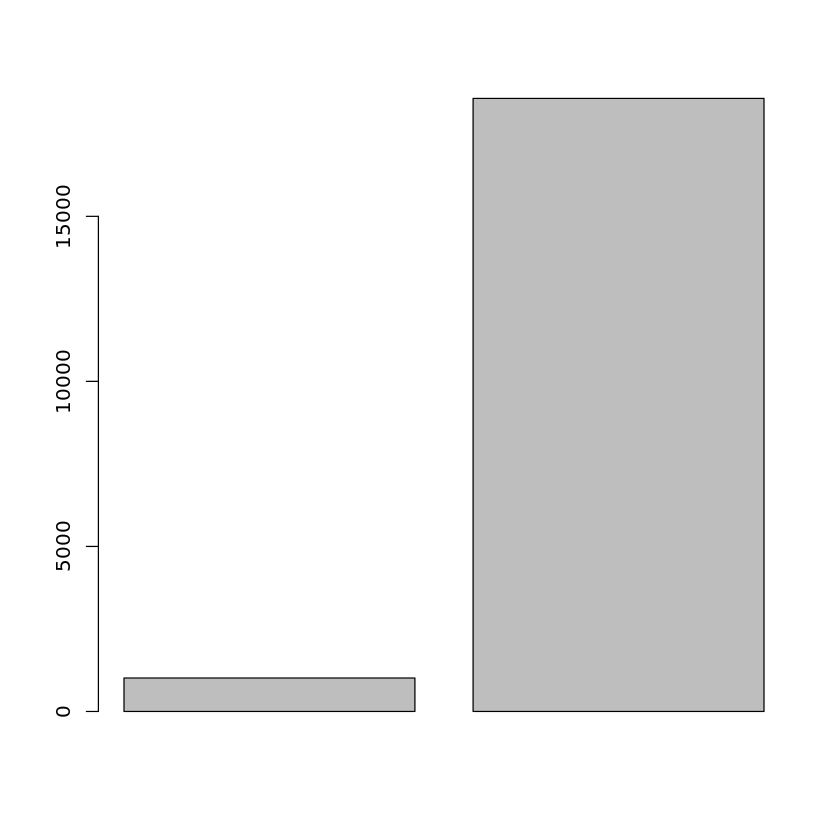

In [14]:
##
## Gráfico
##
result <- collect(sql("
SELECT 
    UniqueCarrier, 
    SUM(IsDelayed) AS NumDelays 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
"))
                  
barplot(result$NumDelays)

In [15]:
##
## Tiempo total de retrasos por transportador
##
collect(sql("
SELECT 
    UniqueCarrier, 
    SUM(DepDelay) AS TotalTimeDelay 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
"))

UniqueCarrier TotalTimeDelay
1 XE             47505        
2 WN            978547

In [16]:
##
## Distancia recorrida por operador
##
collect(sql("
SELECT 
    UniqueCarrier, 
    avg(Distance) AS AvgDistanceTraveled 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier 
ORDER BY 
    AvgDistanceTraveled DESC
"))

UniqueCarrier AvgDistanceTraveled
1 XE            738.0678           
2 WN            623.7927

### Retrasos por día de la semana

In [17]:
head(sql("
SELECT 
    DayOfWeek, 
    delayed,
    COUNT(1) AS Count
FROM
    (SELECT
        DayOfWeek,
        IsDelayed AS delayed
     FROM
        flightsView)
GROUP BY 
    DayOfWeek, 
    delayed
ORDER BY 
    DayOfWeek
"))

DayOfWeek delayed Count
1 1         0       11863
2 1         1        2656
3 2         0       12911
4 2         1        1799
5 3         1        1434
6 3         0       13260

### Retrasos por hora del día

In [18]:
head(sql("
SELECT 
    Hour,
    delayed, 
    COUNT(1) AS Count
FROM 
(
    SELECT
        CAST(CRSDepTime / 100 AS INT) AS Hour, 
        IsDelayed AS delayed
    FROM
        flightsView
)
GROUP BY 
    Hour, 
    delayed
ORDER BY 
    Hour
"))

Hour delayed Count
1 6    1        208 
2 6    0       6126 
3 7    1        372 
4 7    0       7274 
5 8    1        547 
6 8    0       5956

## Almacenamiento y lectura de tablas calculadas

### Escritura de resultados en el HDFS con formato ORC

In [19]:
##
## Se salva la tabla calculada al directorio tmp del HDFS.
## Primero se borra si existe.
##
systemp('hdfs dfs -rm -r -f /tmp/flightsWithDelays.orc')

## Se salva en formato ORC
write.orc(flightsWithDelays, "/tmp/flightsWithDelays.orc")

Deleted /tmp/flightsWithDelays.orc


In [20]:
##
## Contenido del directorio donde se salvó la tabla
##
systemp('hdfs dfs -ls /tmp/flightsWithDelays.orc')

Found 3 items
-rw-r--r--   1 vagrant supergroup          0 2019-05-20 23:37 /tmp/flightsWithDelays.orc/_SUCCESS
-rw-r--r--   1 vagrant supergroup     204828 2019-05-20 23:37 /tmp/flightsWithDelays.orc/part-00000-6411fb20-af57-4a81-b21e-b3653adb85d7-c000.snappy.orc
-rw-r--r--   1 vagrant supergroup      92419 2019-05-20 23:37 /tmp/flightsWithDelays.orc/part-00001-6411fb20-af57-4a81-b21e-b3653adb85d7-c000.snappy.orc


### Carga de los resultados desde el HDFS

In [21]:
##
## Se lee la tabla calculada desde el HDFS
##
test <- read.orc("/tmp/flightsWithDelays.orc")
head(test)

Year Month DayofMonth UniqueCarrier FlightNum DepDelay IsDelayed
1 2008 1     3          WN            335       8        0        
2 2008 1     3          WN            3231      19       1        
3 2008 1     3          WN            448       8        0        
4 2008 1     3          WN            1746      -4       0        
5 2008 1     3          WN            3920      34       1        
6 2008 1     3          WN            378       25       1

### Salva el DataFrame como una tabla permamente

In [22]:
##
## La tabla queda guardada en la carpeta
## spark-warehouse del directorio actual
##
systemp('rm -rf spark-warehouse/flightswithdelaystbl')
saveAsTable(flightsWithDelays, "flightswithdelaystbl")

### Tablas almacenadas

In [23]:
collect(sql("SHOW TABLES"))

database tableName            isTemporary
1 default  flightswithdelaystbl FALSE      
2          flightsview           TRUE

## Consultas en un tabla permanente

In [24]:
## 
## Note que cuando la tabla está almacenada de forma
## permanente no es necesario cargarla a la memoria
## para poder usarla.
##
collect(sql("SELECT COUNT(1) AS Total from flightswithdelaystbl"))

Total
1 1e+05

In [25]:
## Se borran las tablas para limpiar el área
## de trabajo.
sql("DROP TABLE flightswithdelaystbl")
collect(sql("SHOW TABLES"))

SparkDataFrame[]

database tableName   isTemporary
1          flightsview TRUE

In [ ]:
sparkR.stop()

---

**Limpieza**

In [26]:
systemp('hdfs dfs -rm /tmp/flights.csv')

Deleted /tmp/flights.csv
